
We're going to study the scattering process 

$$
\begin{aligned}
  e^-+ e^+ → \mu^+ + \mu^- 
\end{aligned}
$$
at an energy close to the treshold one for muon production, i.e. $\sqrt s ≈ 2m_\mu$, performing a MonteCarlo simulation of it.

The process will be analyzed  both in the centre of mass and in the laboratory reference frame, in particular showing the angular, momentum and energy distributions . For this reason In the following we'll refer to quantites in center of mass frame with the '*' symbol after the quantity itself (i.e. $\theta^*$ , $E^*$,...), while quantities expressed in the laboratory frame will be indicated without it


 

All the useful formulas for the following calculations are reported below:


- Differential cross section

$$ \frac{d\sigma}{d\Omega}(\sqrt{s},\theta^*) = \frac{\alpha^2}{4s}\left ( 1-\frac{4m_\mu ^2}{s} \right )^{\frac{1}{2}}\left ( 1-\frac{4m_e^2}{s} \right )^{-\frac{1}{2}}\left ( 1+\frac{4}{s}\left ( m_e^2 + m_\mu^2 \right )+\left ( 1-\frac{4m_e^2}{s} \right )\left ( 1-\frac{4m_\mu ^2}{s} \right )cos^2(\theta^*)\right)$$

- Cross section

$$ \sigma(\sqrt{s}) = \frac{4}{3}\pi \alpha\frac{1}{s^3}\left ( 1-\frac{4m_\mu ^2}{s} \right )^{\frac{1}{2}}\left ( 1-\frac{4m_e^2}{s} \right )^{-\frac{1}{2}}\left ( 2m_e^2+s \right )\left ( 2m_\mu ^2+s \right) $$


It has been obtained from the former equation integrating over all the solid angle, considering $\varphi ∈ \left [ 0,2\pi\right ]$ and $\theta ∈ \left [ 0,\pi\right ]$ 

- Angular distribution

$$  g(s,\theta^*) = \frac{2\pi sin(\theta^*)}{\sigma}\frac{d\sigma}{d\Omega} = \frac{3}{8} \frac{s^2sin(\theta^*)}{\left ( 2m_e^2+s \right )\left ( 2m_\mu^2+s \right )}\left ( 1+\frac{4}{s}(m_e^2+m_\mu^2)+\left ( 1-\frac{4m_e^2}{s} \right) cos^2(\theta^*) \right )$$


To pass from centre of mass reference frame to the laboratory one, we have applied Lorentz transformations to momentum coordinates performing a boost along x-axis, i.e. the direction of motion.

By using 
$$
\begin{aligned}
\beta= \beta_e^*=\frac{v}{c} = \sqrt{1-\frac{4 m_e^2}{s}}
\end{aligned}
$$
and
$$
\begin{aligned}
\gamma= \frac{1}{\sqrt{1-\beta^2}}
\end{aligned}
$$

We thus obtain the boost of the coordinates $(E,\vec{p})$:


$$ \begin{pmatrix} E \ p_x \ p_y \ p_z \end{pmatrix} = \begin{pmatrix} \gamma & \beta \gamma & 0 & 0 \\
    \beta \gamma & \gamma & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \end{pmatrix} \begin{pmatrix} E^* \ p_x^* \ p_y^* \ p_z^* \end{pmatrix} $$

and even the transformation of the angle of production:

$$ tg(\theta) = \frac{sin(\theta^*)}{\gamma\left ( cos(\theta^*) + \beta/\beta_\mu^* \right )}$$

- Energy boost
$$ E = \gamma E^* + \beta \gamma p_x^* $$

- Momentum boost

$$ p_x = \gamma \beta E^* + \beta p_x^* $$ 

In [39]:
### Libraries ###
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy import optimize

In [40]:
#Definition of useful constants
me = 0.51099895000 #MeV    #change
mu = 105.6583755 #MeV      #change
alpha = 0.0072992701

#setting sqrt(s) to 250
sqr_s = 250
s = 250**2
N = 10**5

#Definition of functions

""" Kinematic's formula  """
def b_mu(s):
    return (1 - 4*mu**2/s)**0.5

def b_me(s):
    return (1 - 4*me**2/s)**0.5

def norm(s):
    return (s/4 - mu**2)**0.5



""" Boost formula """

def gamma(s):
    #computing Lorentz factor
    return 1./(np.sqrt(1-b_me(s)**2))

def boost_coordinates(s,px):
    #returning the tuple of boosted coordinates (E,p)
    return (gamma(s)*(s**0.5/2+b_me(s)*px), gamma(s)*(b_me(s)*s**0.5/2+px))

def tan_boost_ang(theta):
    #returns tangent of angle in lab frame 
    return np.sin(theta) * (1 - b_me(s))**0.5 / (np.cos(theta) + b_me(s)/b_mu(s)) 


def sigma_diff (s,theta):
    '''
        Differential cross section formula [MeV^-2 sr^-1]
    '''
    return alpha**2/(4*s) * (b_mu(s)/b_me(s)) * (1. + 4.*(me**2 + mu**2)/s + b_me(s)**2 * b_mu(s)**2 * np.cos(theta)**2)


def sigma(s):
    '''
        Cross section formula [MeV^-2]
    '''
    return (4 * alpha**2 * np.pi)/(3 * s**3) * (b_mu(s)/b_me(s)) * (2 * me**2 + s) * (2 * mu**2 + s)


def ang(s,theta):
    '''
        Angular distribution formula 
    '''
    return(2 * np.pi * np.sin(theta) * sigma_diff(s,theta) / sigma(s))


def g_cdf(s, theta):
    '''CDF for the theta* distribution'''
    
    return (4 * (2 * me**2 + s) * (2 * mu**2 + s) - 3 * s * (4 * me**2 + 4 * mu**2 + s) * np.cos(theta) + (4 * me**2 - s) * (-4 * mu**2 + s) * np.power(np.cos(theta),3)) / \
           (8 * (2 * me**2 + s) * (2 * mu**2 + s))

# 1) Cross section and differential cross section plots

(210.0, 230.0)

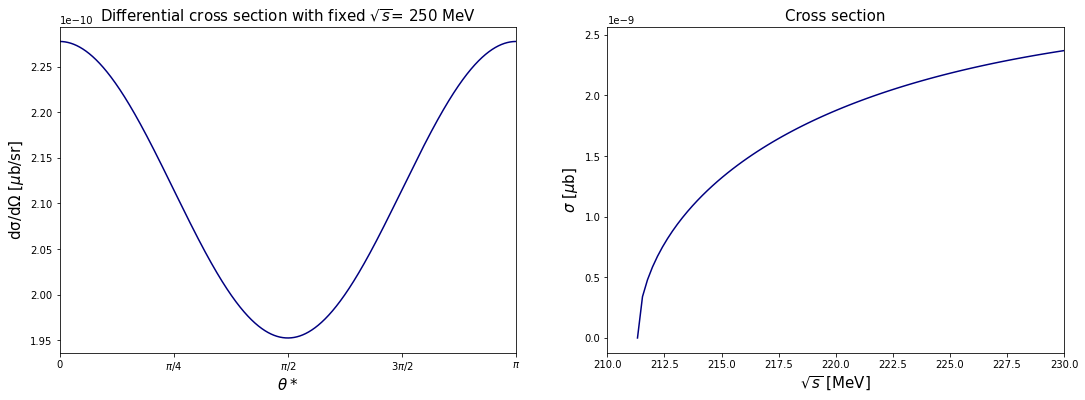

In [41]:
#plotting the results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

#creating the angle grid between 0 and pi 
theta = np.linspace(0,np.pi,N)

#set titles
ax[0].set_title('Differential cross section with fixed $\\sqrt{s}$= 250 MeV', size = 15)
ax[1].set_title('Cross section', size = 15)

#set labels
ax[0].set_xlabel('$\\theta*$', size = 15)
ax[0].set_ylabel(r'$\rm{d}\sigma$/$\rm{d}\Omega$ [$\mu$b/sr]', size = 15)

ax[1].set_xlabel(r'$\sqrt{s}$ [MeV]', size = 15)
ax[1].set_ylabel(r'$\sigma$ [$\mu$b]', size = 15)

#setting x lables in rad for differential cross section plot
ax[0].xaxis.set_major_locator(MultipleLocator(np.pi/4))
#ax[0].xaxis.set_minor_locator(AutoMinorLocator(3))
ax[0].set_xticklabels(['0','0','$\\pi/4$','$\\pi/2$','$3\\pi/2$','$\\pi$'])

#set x spacing for cross section plot
x = np.linspace(2*mu,233,100)

#plot 
ax[0].plot(theta,sigma_diff(s,theta),  linestyle = '-', color = 'navy')
ax[1].plot(x,sigma(x**2),  linestyle = '-', color = 'navy')

#setting x range 
ax[0].set_xlim(0,np.pi)
ax[1].set_xlim(210,230)


# Angular distribution ($\theta^*$)

Since we now need to produce and plot the angular distribution of the scattering process, we find the CDF of the distribution itself and we invert it, using the **inverse transform method**. 

While the CDF can be computed by integrating analytically the function of the distribution, the inversion can not be obtained in an analytical way, so that we choose to use the interpolation method. By firstly generating a sufficient number of points following a uniform distribution in [0,1] and then using the inverse of our distribution, we can obtain the samples we need.

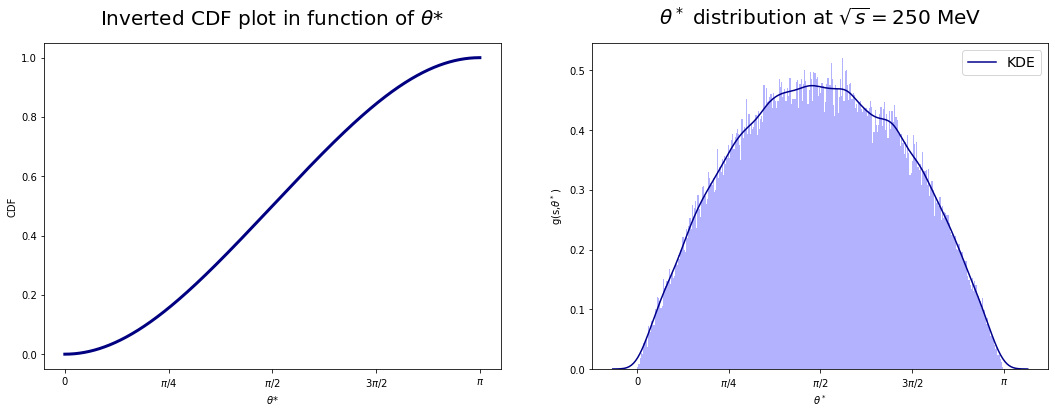

In [42]:
N = 10**5
samples = np.random.uniform(size= N)

#Compute inverse CDF of g(theta*) by interpolation
CDF_inversion = interp1d(g_cdf(250**2, theta), theta, fill_value="extrapolate") 

#histogram plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

ax[0].plot(theta,g_cdf(s,theta),color = 'navy',linewidth = 3)

#definitely sus that it results like this, since in my file is correct...
sns.distplot(CDF_inversion(samples), ax = ax[1],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))


#setting labels, title and ticks
ax[0].set_title('Inverted CDF plot in function of $\\theta$*', pad = 18, fontsize=20)
ax[0].set_xlabel(r'$\theta$*')
ax[0].set_ylabel('CDF')
ax[0].xaxis.set_major_locator(MultipleLocator(np.pi/4))
ax[0].set_xticklabels(['0','0','$\\pi/4$','$\\pi/2$','$3\\pi/2$','$\\pi$'])

ax[1].set_title(r'$\theta^*$ distribution at $\sqrt{s}=$250 MeV', pad = 18, fontsize=20)
ax[1].set_xlabel('$\\theta^*$')
ax[1].set_ylabel('g(s,$\\theta^*$)')
ax[1].xaxis.set_major_locator(MultipleLocator(np.pi/4))
ax[1].set_xticklabels(['0','0','$\\pi/4$','$\\pi/2$','$3\\pi/2$','$\\pi$'])

#plot legend and graph
ax[1].legend(loc = 'best', fontsize = 14)
plt.show()

# Momenta distribution

According to the cilindrical symmetry of the process, we expect that the momentum components along y-axis and z-axis will behave the same. 
Moreover, the muons will be produced with supplementary angles and same momentum components distributions. 

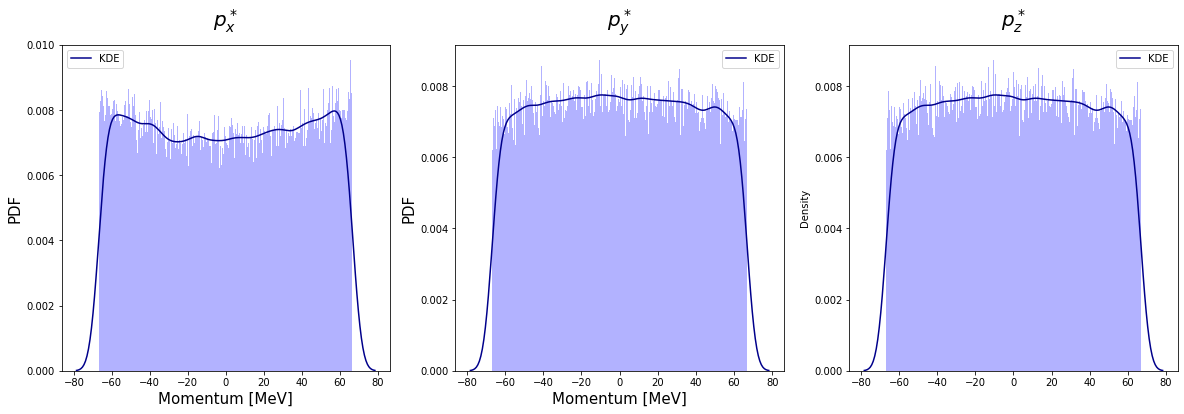

In [43]:
#Momenta plot in CM
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

#set titles
ax[0].set_title('$p_x^*$', pad = 18, fontsize=20)
ax[1].set_title('$p_y^*$', pad = 18, fontsize=20)
ax[2].set_title('$p_z^*$', pad = 18, fontsize=20)

#set labels 
ax[0].set_xlabel('Momentum [MeV]', size = 15)
ax[0].set_ylabel('PDF', size = 15)

ax[1].set_xlabel('Momentum [MeV]', size = 15)
ax[1].set_ylabel('PDF', size = 15)

#set projections of momenta
phi_ang   = np.random.uniform(0, 2 * np.pi, size=N)
px = norm(s) * np.cos(CDF_inversion(samples)) 
py = norm(s) * np.sin(CDF_inversion(samples)) * np.cos(phi_ang)
pz = py

#plot 
sns.distplot(px, ax = ax[0],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))
sns.distplot(py, ax = ax[1],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))
sns.distplot(pz, ax = ax[2],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))

ax[0].legend(loc= 'best')
ax[1].legend(loc= 'best')
ax[2].legend(loc= 'best')

# Boost to the laboratory frame
By using the previously justified formulas, we can find the coordinates and the angles in the laboratory frame, starting from the same values obtained for the center of mass frame. 

In [44]:
#boost all the quantities to the laboratory frame
(E_lab, px_lab) = boost_coordinates(s,px)
tan_theta_lab_m1 = tan_boost_ang(CDF_inversion(samples))
tan_theta_lab_m2 = tan_boost_ang((-1)*CDF_inversion(samples))

theta_lab_m1 = np.arctan(tan_theta_lab_m1)
theta_lab_m2 = np.arctan(tan_theta_lab_m2)


# Angular distribution ($\theta$)
In the following plots we can easily notice that, since the angles of productions are quite small, plotting $tan(\theta)$ or $\theta$ itself does not give any visible difference.

<AxesSubplot:title={'center':'Angular distribution in laboratory frame'}, xlabel='$\\theta$', ylabel='PDF'>

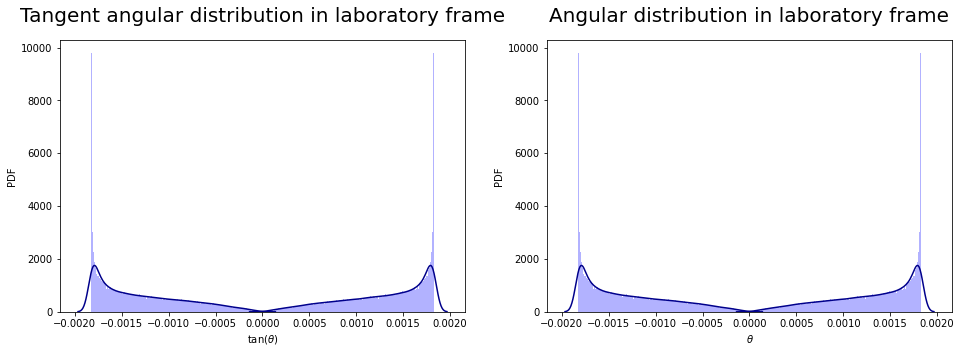

In [45]:
#plotting the angular distribution
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,5))

#setting title and labels
ax[0].set_title('Tangent angular distribution in laboratory frame', pad = 18, fontsize=20)
ax[0].set_xlabel('tan($\\theta$)')
ax[0].set_ylabel('PDF')

ax[1].set_title('Angular distribution in laboratory frame', pad = 18, fontsize=20)
ax[1].set_xlabel('$\\theta$')
ax[1].set_ylabel('PDF')

#plot 
sns.distplot(tan_theta_lab_m1, ax = ax[0],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))
sns.distplot(tan_theta_lab_m2, ax = ax[0],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))

sns.distplot(theta_lab_m1, ax = ax[1],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))
sns.distplot(theta_lab_m2, ax = ax[1],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))

# Momentum and energy distribution

Since the boost is applied along the x-axis, the other momentum components ($p_y, p_z$) are left unmodified and it is not interesting to replot them. 

<AxesSubplot:title={'center':'$p_x$'}, xlabel='$p_x$ [MeV]', ylabel='PDF'>

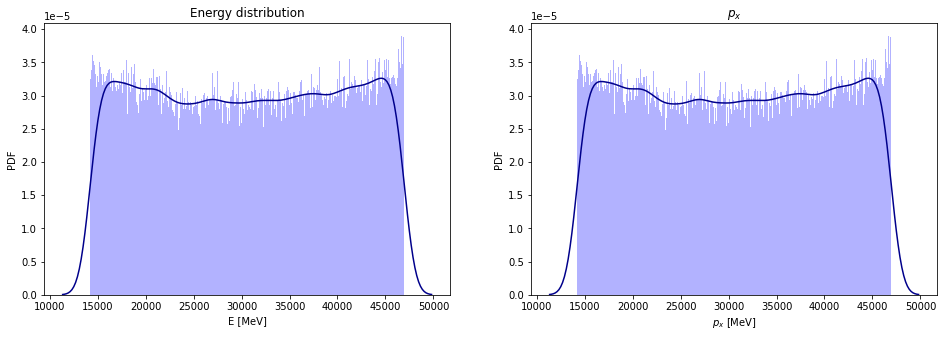

In [46]:
#plotting the momentum and energy distribution

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,5))

#setting title and labels
ax[0].set_title('Energy distribution')
ax[0].set_xlabel('E [MeV]')
ax[0].set_ylabel('PDF')

ax[1].set_title('$p_x$')
ax[1].set_xlabel('$p_x$ [MeV]')
ax[1].set_ylabel('PDF')

#plotting histograms
sns.distplot(E_lab, ax = ax[0],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))
sns.distplot(px_lab, ax = ax[1],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))

# Montecarlo with monochromatic beam

The first simulation of the scattering process is based on a monochromatic positron beam, i.e. it has the following characteristics:
- we assume its transversal section to be point-like;
- all the beam particles have the same energy.

In order to sample $\theta$ distributed according to the differential cross section, we will use the inverse transform method. 
Since we know the analytic form of CDF of the angular distribution in the CoM frame $g(\theta^*)$, this approach can be applied and 
leads to better performances. The distribution $h(\varphi^*)$ is infact uniform in the interval [0,$2\pi$]. Namely we have:

$$
g(\theta^*) = \frac{2\pi \sin(\theta^*)}{\sigma^*} \cdot \frac{\mathrm{d}\sigma^*}{\mathrm{d}\Omega^*} \quad \quad \text{and} \quad \quad h(\varphi^*) = \frac{1}{2\pi}

$$

The CDF is computed through the following: 

\begin{align}
\text{CDF}[ g(\theta^*)]=  \int_0^{\theta^*} g(\theta^*)  \mathrm{d}\theta^*  
= \int_0^{\theta^*} \frac{2\pi \sin(\theta^*)}{\sigma} \cdot \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}\left[ 1+ \frac{4}{s} (m_e^2 + m_\mu^2) + \left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)\cos^2\theta^*\right]  \\ = 
\frac{2\pi}{\sigma} \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}
    \cdot \left\{\left[1+ \frac{4}{s} (m_e^2 + m_\mu^2)\right] (1 - \cos\theta^*) + \frac{1}{3}\left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)(1 - \cos^3\theta^*)\right\} \tag{0.1}
\end{align}

To generate the events:

$a_i$ random uniform in [0,1] $\implies$ CDF[$g(\theta^*)]^{-1}$($a_i$) =$\theta^*_i \\$ 
$b_i$ random uniform in [0,$2\pi$] $\implies$ CDF[$h(\theta^*)]^{-1}$($b_i$) =$\varphi^*_i $

The inverse of the CDF is computed by interpolation through different methods available in the scipy library, i.e. ``UnivariateSpline``, ``InterpolatedUnivariateSpline`` and ``interp1d``.


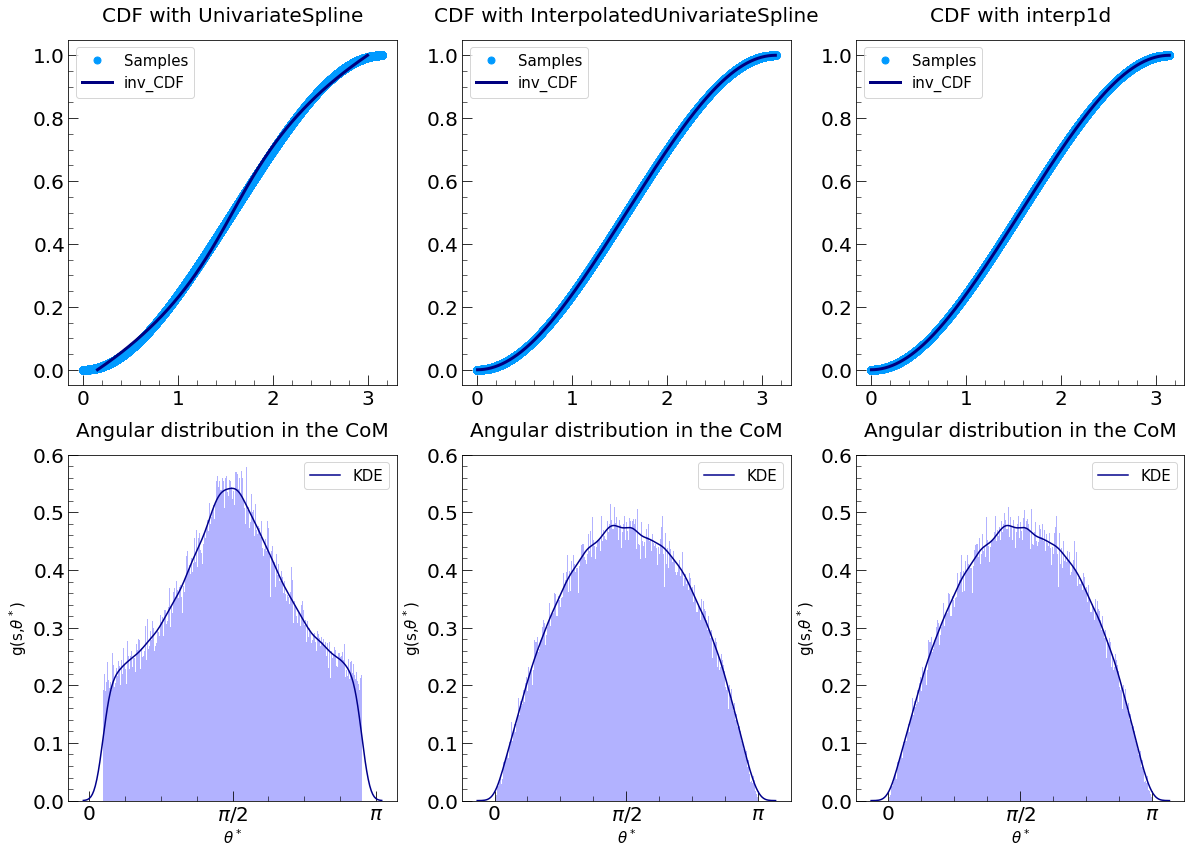

In [47]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

# Angles in the CoM frame on which we sample the inverse CDF
theta_star = np.linspace(0, np.pi, N)

s = sqr_s**2 

# three version of inverse CDF sampling
inv_cdf1 = UnivariateSpline(g_cdf(s,theta_star),theta_star, ext=0)
inv_cdf2 = InterpolatedUnivariateSpline(g_cdf(s,theta_star),theta_star, ext=0)
inv_cdf3 = interp1d(g_cdf(s, theta_star), theta_star, fill_value='extrapolate') #'extrapolate' is needed for the points at z=0,1, which are 'very slightly' outside of the samples
    
# Sample some angles
num_samples = N
unif_samples = np.random.uniform(size=num_samples)
samples_sorted = np.sort(unif_samples)

phis = np.random.uniform(0, 2 * np.pi, size=num_samples)

#same plot on each ax of the points
for i in range(3):
    ax[0][i].plot(theta_star,g_cdf(s,theta_star),'o',markersize= 7,color = '#009AFF',label='Samples')
    ax[1][i].set_title('Angular distribution in the CoM', pad = 18, fontsize=20)
    ax[1][i].set_ylim(0,0.6)
    ax[1][i].set_xticks([0,np.pi/2,np.pi],['0','$\\pi/2$','$\\pi$'] )
    ax[1][i].set_xlabel('$\\theta^*$',fontsize = 15)
    ax[1][i].set_ylabel('g(s,$\\theta^*$)',fontsize = 15)   


### UnivariateSpline ###
ax[0][0].set_title('CDF with UnivariateSpline', pad = 18, fontsize=20)
ax[0][0].plot(inv_cdf1(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf1(samples_sorted), ax = ax[1][0],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, bins = int(np.sqrt(N)))


### InterpolatedUnivariateSpline ###
ax[0][1].set_title('CDF with InterpolatedUnivariateSpline', pad = 18, fontsize=20)
ax[0][1].plot(inv_cdf2(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf2(samples_sorted), ax = ax[1][1],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, bins = int(np.sqrt(N)))

### interp1d ###
ax[0][2].set_title('CDF with interp1d', pad = 18, fontsize=20)
ax[0][2].plot(inv_cdf3(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf3(samples_sorted), ax = ax[1][2],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},bins = int(np.sqrt(N)))

for ax in fig.get_axes():
    # plot settings                    
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15)
    
plt.show()


Different interpolating functions lead to different distribution: in particular the ``InterpolatedUnivariateSpline``method is not able to fit the extremes providing a wrong angular distribution. 
We then decide to use the ``interp1d`` method. 

In order to generate the scattering events we definie a routine that is implemented in the function `generate_beam`, which returns the two muons 3-momenta in the laboratory frame. 

In [48]:
def generate_beam(sqr_s, batch_size = 10**5):
    '''Function that generates one batch of scattering events
    
    Parameters:

    sqr_s : Center of mass energy (sqrt(s)) in MeV (must be > 2 mu)
           
    batch_size : Number of events in one batch


    Returns: 
    ndarray of size (batch_size, 6)
    Each row is one event, and contains the components of the 3-momenta (in the laboratory frame)
     of the muon-antimuon pair, in [MeV/c]
     
    '''
    
    assert sqr_s > 2 * mu, 'There is not enough energy for muon pair production'
    s = sqr_s**2 

    pnorm = norm(s) # Norm of muon 3-momentum in CM
    
    # Compute inverse CDF of g(theta*) by interpolation 
    theta_star = np.linspace(0, np.pi, N)
    inv_cdf = interp1d(g_cdf(s, theta_star), theta_star, fill_value='extrapolate')

    # Sample angles
    num_samples = N
    unif_samples = np.random.uniform(size=batch_size)

    phis = np.random.uniform(0, 2 * np.pi, size=batch_size)
    thetas = inv_cdf(unif_samples)
    
    
    # Compute cartesian components of 3-vector
    px_cm = pnorm * np.cos(thetas)
    py_cm = pnorm * np.sin(thetas) * np.cos(phis)
    pz_cm = pnorm * np.sin(thetas) * np.sin(phis)


    _,px1 = boost_coordinates(s, px_cm)  # px for first muon
    _,px2 = boost_coordinates(s, -px_cm) # px for second muon
    # py and pz are orthogonal to boost axis, and so they remain the same
    
    return np.stack((px1, py_cm, pz_cm, px2, -py_cm, -pz_cm), axis=1)    




In [49]:
# generate events 
events = generate_beam(250, 10**5)
# save events in txt file and dataframe 
np.savetxt("Momenta_monochromatic.txt", events) # save to file
df_monochromatic = pd.DataFrame(events, columns = [  '$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])
df_monochromatic.to_csv('Events.csv')
df_monochromatic

,$px_{\mu_1}$,$py_{\mu_1}$,$pz_{\mu_1}$,$px_{\mu_2}$,$py_{\mu_2}$,$pz_{\mu_2}$
0,25805.047305,59.123773,-24.189248,35349.166180,-59.123773,24.189248
1,17438.283752,-24.650379,-31.124785,43715.929733,24.650379,31.124785
2,33132.951223,-35.461651,-55.629243,28021.262262,35.461651,55.629243
3,26003.394172,61.008597,19.740055,35150.819313,-61.008597,-19.740055
4,42156.163255,14.545532,-44.823262,18998.050230,-14.545532,44.823262
...,...,...,...,...,...,...
99995,27719.293311,6.478420,-65.443501,33434.920174,-6.478420,65.443501
99996,29564.569220,66.547839,3.944553,31589.644265,-66.547839,-3.944553
99997,34650.486881,-28.375657,-58.127812,26503.726603,28.375657,58.127812
99998,27910.627861,54.602110,36.893027,33243.585624,-54.602110,-36.893027


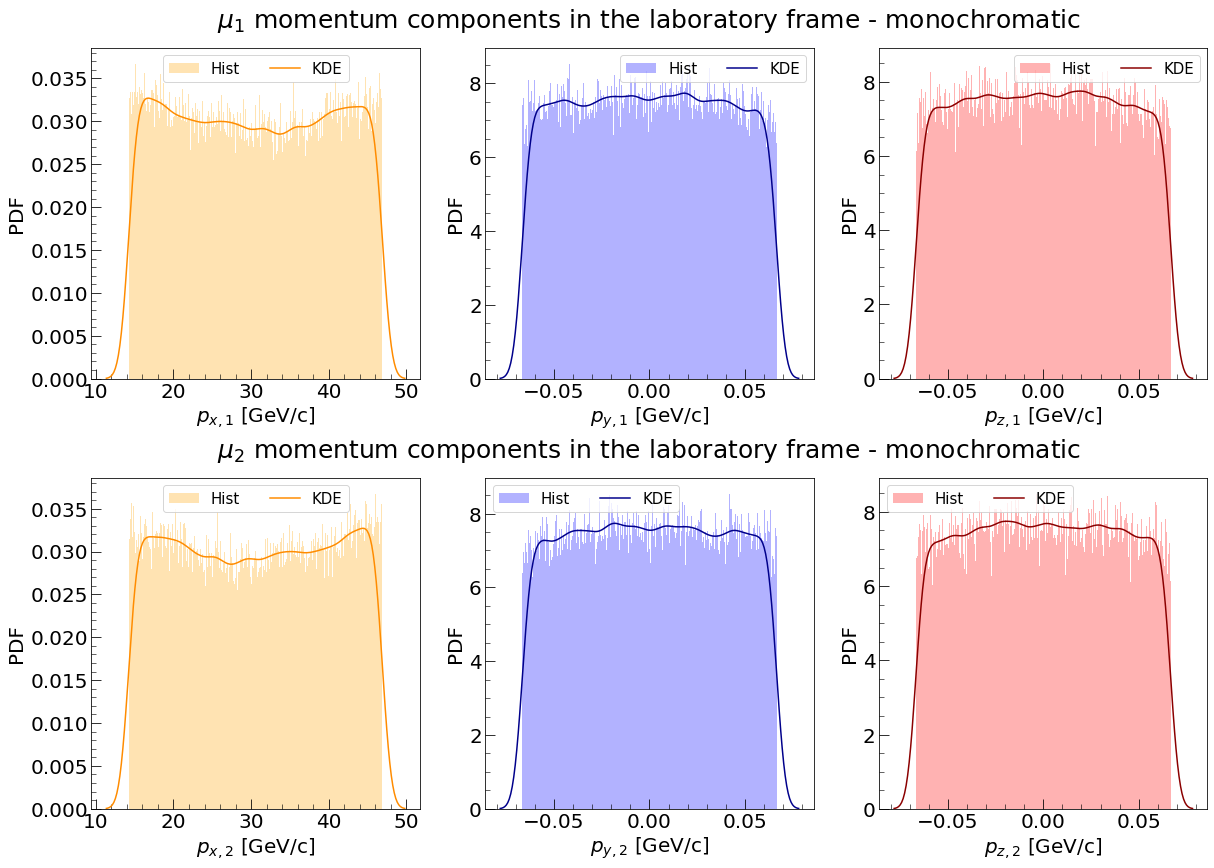

In [50]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

#plotting momentum components distribution in the LAB frame


### MUON 1 ###
# px
sns.distplot(df_monochromatic['$px_{\mu_1}$']/1000,
             ax = ax[0][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )

            
# py
sns.distplot(df_monochromatic['$py_{\mu_1}$']/1000,
             ax = ax[0][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkblue',   'label': 'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic['$pz_{\mu_1}$']/1000,
             ax = ax[0][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred',   'label': 'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[0][0].set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)
ax[0][1].set_xlabel(r'$p_{y,1}$ [GeV/c]',fontsize = 20)
ax[0][2].set_xlabel(r'$p_{z,1}$ [GeV/c]',fontsize = 20)

ax[0][1].set_title('$\mu_1$ momentum components in the laboratory frame - monochromatic',fontsize = 25,pad = 20)


### MUON 2 ###
# px
sns.distplot(df_monochromatic['$px_{\mu_2}$']/1000,
             ax = ax[1][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# py
sns.distplot(df_monochromatic['$py_{\mu_2}$']/1000,
             ax = ax[1][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws = {'color':'darkblue','label':'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic['$pz_{\mu_2}$']/1000,
             ax = ax[1][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred', 'label':'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[1][0].set_xlabel(r'$p_{x,2}$ [GeV/c]',fontsize = 20)
ax[1][1].set_xlabel(r'$p_{y,2}$ [GeV/c]',fontsize = 20)
ax[1][2].set_xlabel(r'$p_{z,2}$ [GeV/c]',fontsize = 20)

ax[1][1].set_title('$\mu_2$ momentum components in the laboratory frame - monochromatic',fontsize = 25, pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)


plt.subplots_adjust(hspace=.3)
plt.show()



The momentum y and z components show a uniform distribution, centered in zero, as expected. On the other hand the x component distribution presents a negative concavity
with peaks at the extremes of the interval. In order to analyze how this distribution changes according to the inveriant mass, we generate events with 
$\sqrt{s}$ = $2m_{\mu} + \epsilon$, where $\epsilon$ is a quantity that will be varied in a certain range.

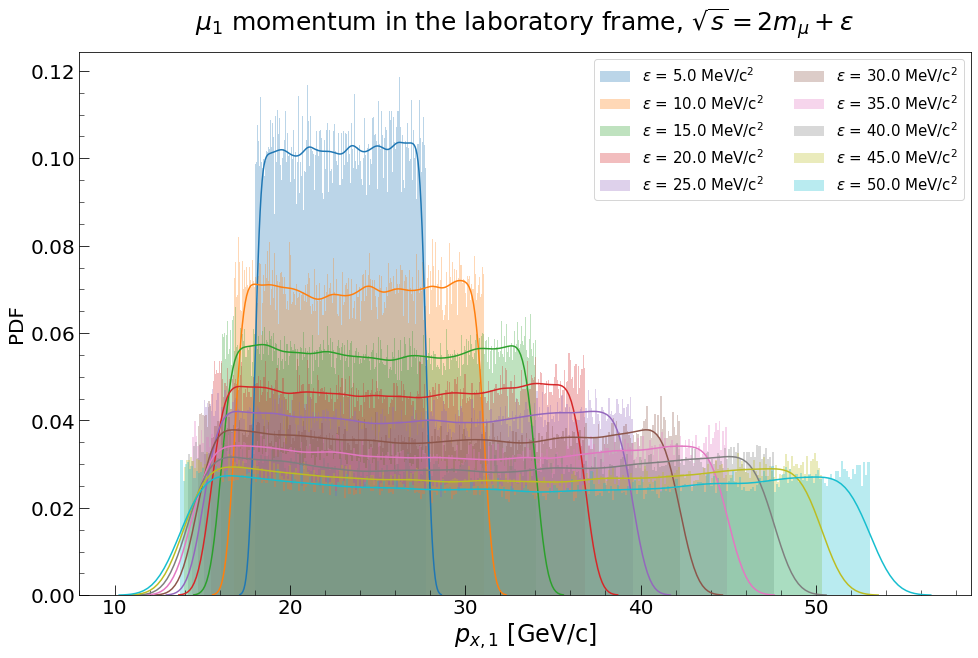

In [51]:
### P_x distribution in function of available energy ###
epsilon = 0.1

for i in range(1,11):
    epsilon = i*5
    sqr_s = 2*mu + epsilon
    events = generate_beam(sqr_s, 10**5)
    globals()[f'df{i}'] = pd.DataFrame(events, columns = [ '$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])


fig, ax = plt.subplots(1,1, figsize = (16,10))

# plotting momentum components distribution in the LAB frame

for i in range(1,11):
    epsilon = 5*i
    sns.distplot(globals()[f'df{i}']['$px_{\mu_1}$']/1000,
                ax = ax,
                bins = int(np.sqrt(N)),
                kde = True,
                #kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
                hist_kws = { 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': '$\epsilon$ = {:.1f} MeV/c$^2$'.format(epsilon)}
                )

ax.set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 24)
ax.set_title('$\mu_1$ momentum in the laboratory frame, $\sqrt{s}=2m_{\mu}+\epsilon$',fontsize = 25,pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)

plt.show()

# Beryllium target 
The number of $\mu^+ \mu^-$ pairs produced per positron bunch on target is given by:
$$n_\mu =  n_+ \rho^- l_t \sigma $$
where $n_+$ is the number of positrons in the bunch, $\rho^-$ is the electron density in the medium, $l_t$ is the thickness of the target, and $\sigma$ is the total cross section for the $e^+ e^- \to \mu^+ \mu^-$ process.
We can then express it as a function of the impinging positrons rate $f_+$, which reads:
$$f_\mu =  f_+ \rho^- l_t \sigma $$

 $\rho^-$ can be computed as:
$$ \rho^- = N_A \frac{\rho_{\mathrm{Be}}}{M_t} Z $$
with $\rho_{\mathrm{Be}}$ being the target's density, $M_t$ its molar mass, and $Z$ its atomic number. [cite LEMMA article]

So, if we generate $N$ events, the correct statistics for an experiment carried out for a time interval $\Delta T$ can be computed by rescaling histograms by a factor $W = f_\mu \Delta T / N$, with $\Delta T$ in seconds.

Muon pairs produced per second:  2.9886879853129447
Muon pairs produced in a week:  1807558.493517269


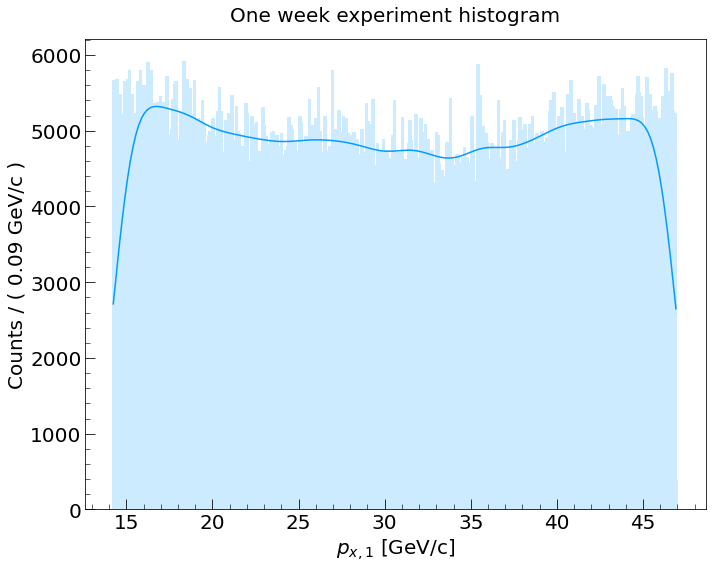

In [52]:

s = 250**2 

cross_sec = sigma(s) * 389.4 * 1e-24 # Total cross section [cm^2]

freq    = 1e6       # Positrons rate on target [Hz]
rhoBe = 1.848       # Beryllium density     [g/cm^3]
MBe   = 9.012       # Beryllium molar mass  [g/mol]
ZBe   = 4           # Beryllium atomic number
lt    = 6           # Target thickness      [cm]
N_a    = 6.022e23   # Avogadro's number     [mol^-1]


T     = 3600 * 24 * 7   # seconds in a week

rho_electrons = N_a * rhoBe * ZBe / MBe         # Be Electron density [n.e-/cm^3]
fmu    = freq * rho_electrons * lt * cross_sec  # Rate of produced muon pairs [Hz]
N_week = fmu * T                                # Number of muons produced in a week (rescaling factor)


print("Muon pairs produced per second: ", fmu)
print("Muon pairs produced in a week: ", N_week)


weights = np.full(int((N)), N_week/N)                     # array of rescaling factors
df_monochromatic['weights']=weights  


fig, ax = plt.subplots(1, figsize = (10,8))

sns.histplot(x=df_monochromatic['$px_{\mu_1}$']/1000,
             ax=ax,
             stat='count',
             weights= df_monochromatic['weights'], 
             bins = int(np.sqrt(N)), 
             kde=True,
             lw=2,
             edgecolor   = "#ccebff",
             color       = "#009CFF",
             binwidth = 0.09
              )


ax.set_title("One week experiment histogram",fontsize = 20, pad = 18)
ax.set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)

# plot settings   
ax.set_ylabel('Counts / ( 0.09 GeV/c )',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()


fig.tight_layout()
plt.show()

## Non-monochromatic beam
Now we deal with a non pointlike beam, indeed it has transverse dimensions (along y and z coordinates).

Moreover another important change has to be considered: the beam is not monochromatic anymore but the energy of the positrons follows a gaussian distribution with a width of $500 MeV$.

First of all, we want to plot the gaussian distribution of energy to have an idea of the distance between the nominal energy and the threshold energy.

To visualize the geometry of the beam, we consider the number of muons arriving every second: $10^6 \mu/s$. These particles will be distributed according to a uniform distribution in circle of radius $1cm$.
We can generate random numbers between [0-1] for the $y$ and $z$ coordinate and use the Acceptance-Rejection method to have a distribution of positrons hitting on the target every second.

We neglect shadow effect, this means that positrons "behind" other positrons are not affected by this configuration. This is a good approximation for relativistic particles we are dealing with.

In [53]:
#Number of muons per seconds (should be 10**6 but requires too much time in the end I will modify it)
N = 10**4
s = 220**2
#y and z position coordinates generated uniformly in the following array  [[Y-vector],[Z-vector]]
muons = [[],[]]


while (len(muons[0])<N):
    #linear transformation to include all the circle and not only the first quarter:
    #random number between -1 and 1
    y = np.random.random()*2-1
    z = np.random.random()*2-1


    if (y**2+z**2<1):
        muons[0]=np.append(muons[0],y)
        muons[1]=np.append(muons[1],z)

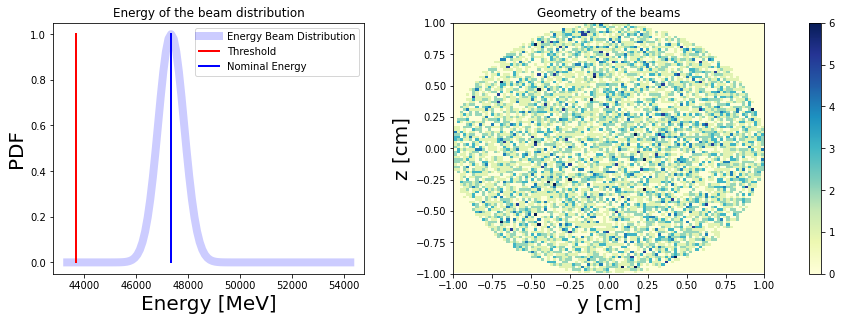

The distance between the nominal energy and the threshold energy is 7.3 sigmas 


In [54]:
#Energy in the CM is now distributed with a gaussian peaked at E_cm
#Energy of the positron in the LAB (NOMINAL ENERGY)
E_p = s/(2*me)- me
#width of the gaussian energy
width = 500
#the energy threshold in the cm is s=4*mu**2 but s=2me**2+2*E_pos*me
threshold = 4*mu**2/(2*me)-me

def EnergyBeam(x):
    return (np.exp(-((x-E_p)**2/(2*width**2))))

#plot the gaussian distribution graphically
xaxis_energy = np.arange(E_p-8*width,E_p+14*width,100)
yaxis = EnergyBeam(xaxis_energy)



#graphic
fig, ax = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(pad=8.0)
ax[0].plot(xaxis_energy, yaxis, color='b', lw=8,label="Energy Beam Distribution",alpha=0.2)
ax[0].set_title('Energy of the beam distribution')
ax[0].set_xlabel('Energy [MeV]',fontsize=20)
ax[0].set_ylabel('PDF', fontsize=20)
line_x = [threshold, threshold]
line_x2 = [E_p, E_p]
line_y = [0, 1]
ax[0].plot(line_x, line_y, c='r', label='Threshold', lw=2)
ax[0].plot(line_x2, line_y, c='b', label='Nominal Energy',lw=2)
ax[0].legend(loc='upper right')



h=ax[1].hist2d(muons[0], muons[1],bins=100, cmap='YlGnBu')
ax[1].set_title('Geometry of the beams')
ax[1].set_xlabel('y [cm]',fontsize=20)
ax[1].set_ylabel('z [cm]',fontsize=20)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
fig.colorbar(h[3], ax=ax)
plt.show()

dist=np.abs(E_p-threshold)/width
print("The distance between the nominal energy and the threshold energy is %.1f sigmas " %dist )

Since the energy of positrons is not constant anymore, the Mandelstam variable $\sqrt{s}$ will assume different values for every process $e^{+}+e^{-} \rightarrow \mu^{+}+\mu^{-}$. This also implies that we have to perform different Lorentz boost for each reaction considered.


To do so, we proceeded with this general scheme:

* Generate energy of positron in the lab with the gaussian distribution plotted above $E_{pos}^{lab}$
* From the energy get $\gamma$ factor of positron in the lab $\gamma= \frac{E_{pos}^{lab}}{m_e}$
* Get $\beta$ from $\gamma$
* Get spatial momentum modulus of the positrons in the lab $p_{pos}^{lab}=m_e\cdot\beta_{pos}^{lab}\cdot\gamma_{pos}^{lab}$
* Find invariant mass for that energy knowing both the energy and the momentum of the positron and the electron: $M^2=s=\left(p_{e+}^{\mu}+p^{e-}_{\mu}\right)^2$
* Get $\gamma_{boost}$ of the center of mass frame with respect to the lab from the total energy in the two frames: $\gamma_{boost}=\frac{E_{pos}^{lab}+m_e}{M} $:
* get $\beta_{boost}$ from $\gamma_{boost}$

With $\beta_{boost}$ and $\gamma_{boost}$ we can perform whatever lorentz transformation between the two frames, aiming to get the momentum distribution in the lab frame.

Finally, we will generate $\phi$ angle uniformly and $\theta$ angle according to the distribution $g(\theta^*)$. We will boost this angle knowing $\beta_{boost}$ and $\gamma_{boost}$ for that energy.

In order to get a set with sufficient statistics, we will repeat this scheme for $10^5$ times

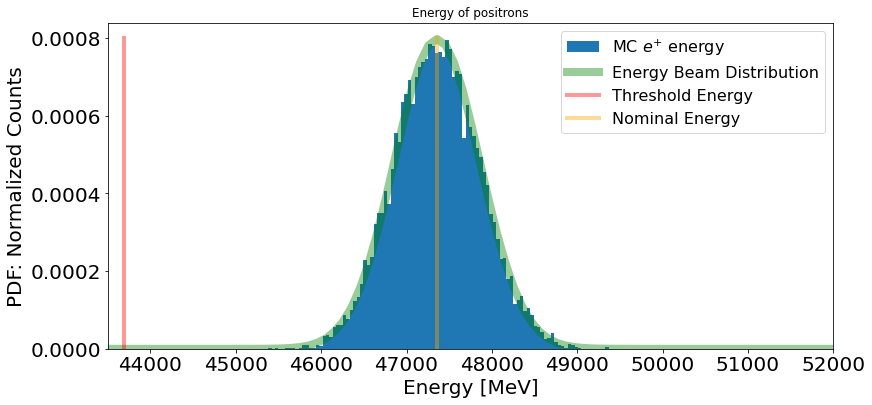

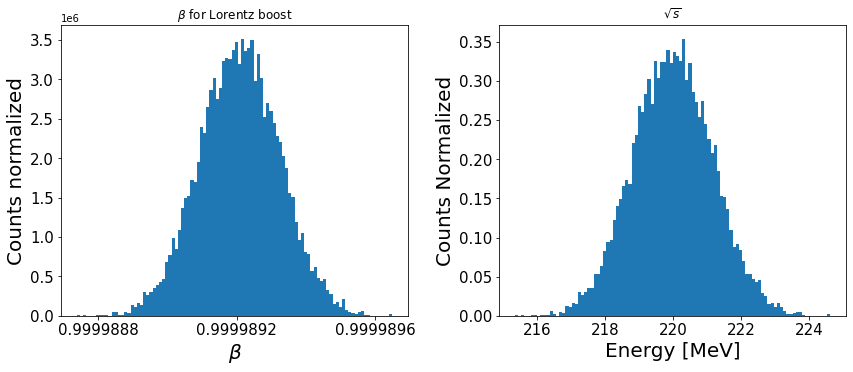

In [55]:
#Here there are the numpy arrays with the useful kinematic variables

#Set of energy of the positron distributed gaussian
E_pos_lab_gaus = np.random.normal(E_p, width, N)

#Gamma factor for each positron in the lab
gamma_pos_lab = E_pos_lab_gaus/me            #v

#beta factor for each positron (velocity of the positron in the lab)
beta_pos_lab = np.sqrt(1-1/gamma_pos_lab**2)  #v

#momentum of each positron in the lab
p_pos_lab = me*beta_pos_lab*gamma_pos_lab    #v

#invariant mass aka sqrt(s)
M = np.array([])
M = np.sqrt(2*me**2+2*E_pos_lab_gaus*me)    #v

#gamma and beta of the cm wrt lab (the ones to be used for the boost of positrons)
gamma_boost = (E_pos_lab_gaus+me)/M          #correction! me    v
beta_boost = np.sqrt(1-1/gamma_boost**2)      #v

#velocity in the CoM Frame
#beta_cm = s/(s+2*mu**2)

#for the boost of angles we need beta in CoM for the muons!   v
beta_cm_mu=np.sqrt((M**2-4*mu**2)/(M**2))


fig, axes = plt.subplots(1,1,figsize=(13,6))

axes.hist(E_pos_lab_gaus,bins=100,density=True, label="MC $e^{+}$ energy")
axes.set_title("Energy of positrons")
axes.plot(xaxis_energy, yaxis/np.sqrt(2*np.pi*width**2), color='g', lw=8,label="Energy Beam Distribution",alpha=0.4)

#Plotting threshold
line_y = [0, 0.0008]
line_x2 = [E_p, E_p]
axes.plot(line_x, line_y, c='r',lw=4,alpha=0.4, label='Threshold Energy ')

#Plotting nominal energy
axes.plot(line_x2, line_y, c='orange', lw=4, alpha=0.4,label='Nominal Energy')

#graphic stuffs
axes.set_xlim(43500,52000)
axes.set_xlabel("Energy [MeV]",fontsize=20)
axes.set_ylabel('PDF: Normalized Counts',fontsize=20)
axes.tick_params(axis='both', which='major', labelsize=20)
axes.legend(loc='best',prop={'size': 16})
plt.show()




# plot of beta and sqrt(s)
fig, axes2 = plt.subplots(1,2,figsize=(13,6))
fig.tight_layout(pad=6.0)
axes2[0].hist(beta_boost,bins=100,density=True)
axes2[0].set_title("$ \\beta$ for Lorentz boost")
axes2[0].ticklabel_format(useOffset=False, style='sci')
axes2[0].xaxis.set_major_locator(plt.MaxNLocator(3))
axes2[0].set_xlabel("$\\beta$", fontsize=20)
axes2[0].set_ylabel("Counts normalized",fontsize=20)
axes2[0].tick_params(axis='both', which='major', labelsize=15)

axes2[1].hist(M,bins=100,density=True)
axes2[1].set_title("$\\sqrt{s}$")
axes2[1].set_xlabel('Energy [MeV]', fontsize=20)
axes2[1].set_ylabel('Counts Normalized',fontsize=20)
axes2[1].tick_params(axis='both', which='major', labelsize=15)


#axes[2].ticklabel_format(useOffset=False, style='sci')
#axes[2].xaxis.set_major_locator(plt.MaxNLocator(3))


plt.show()

Now that all the kinematic variables are calculated for each of the $10^6$ event that occur per second (assuming energy above the threshold as we will see later), we can generate the angular variables from the knwon distributions. Before doing it let's check if every positron have enough energy to initiate the process:


In [56]:
not_enough=0
for i in E_pos_lab_gaus:
    if i<threshold:
        not_enough=not_enough+1
if not_enough!=0:
    print("%.3f muons do not have enough energy!")
else:
    print("All the muons have enough energy to initiate the process")

All the muons have enough energy to initiate the process


## Muons production
Since all the positrons have enough energy to initiate the process we consider the production of $10^6$ pairs muon-antimuon per seconds emitted after the collision.

Firstly we generate the angular variables in center of mass frame starting from the known distribution. Since no sharp peaks are present in the distribution of $\theta$ we use the acceptance-rejection method.

It is easy to check analytically that the maximum of the function occurs at $ \theta=\frac{\pi}{2}$

Using the Acceptance-Rejection Method one has to know the maximum of the distribution $g(\theta^*)$ that slightly depends on the energy of the process as we can check below

Mean upper limit 0.4934


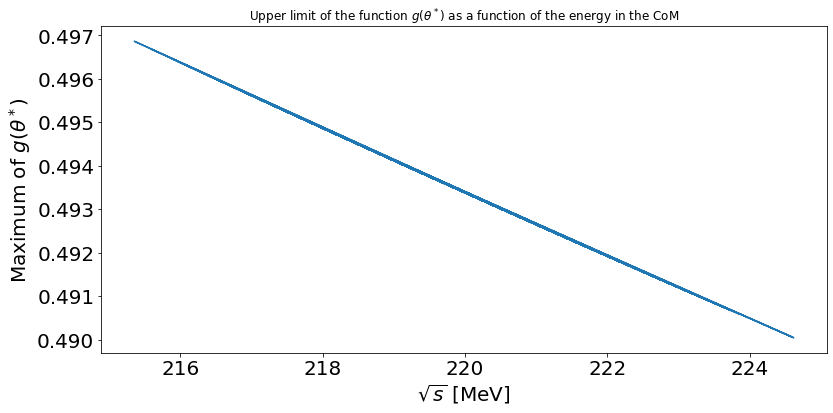

The differences are of the order of 0.705 %


In [57]:
#array for theta angles in the CoM
angle_cm = np.array([])
#notice that the limit depends on the energy (even if very slight dependence)
#array of upper limit of the maximum of the distribution (the max occurs always at pi/2)
s_arr =np.power(M,2)
upper = ang(s_arr, np.pi/2)
print("Mean upper limit %.4f"%np.mean(upper))

#Graphical plot
fig, axes4 = plt.subplots(1,1,figsize=(13,6))
h=axes4.plot(M,upper)
axes4.set_xlabel("$\sqrt{s}$ [MeV]",fontsize=20)
axes4.set_ylabel('Maximum of $g(\\theta^*)$',fontsize=20)
axes4.tick_params(axis='both', which='major', labelsize=20)
axes4.set_title("Upper limit of the function $g(\\theta^*)$ as a function of the energy in the CoM")

plt.show()

val=(upper.max()-upper.mean())/upper.mean()*100
print("The differences are of the order of %.3f" % val,"%") 

In [58]:
#GENERATION OF THETA ANGLES

while len(angle_cm)<N:
    u = np.random.uniform(0, np.pi)
    r = np.random.uniform(0, upper[len(angle_cm)])      #take the upper limit for the specific event depending on the energy of positron
    if (r<ang(M**2,u)[len(angle_cm)]):
        angle_cm=np.append(angle_cm,u)

#generation of phi angle
phi = np.random.uniform(0, 2*np.pi, N)

In [59]:
#Consider the variation of 3 sigma in the energy in the lab, what is the variation of energy in cm?
s1=2*me**2+2*E_p*me
s2=2*me**2+2*((E_p+3*width)*me)
s3=2*me**2+2*((E_p-3*width)*me)
print("Energy in the CoM from E_lab \t\t%.1f MeV"% np.sqrt(s1))
print("Energy in the CoM from E_lab+3*sigma  \t%.1f MeV" %np.sqrt(s2))
print("Energy in the CoM from E_lab-3*sigma  \t%.1f MeV"%np.sqrt(s3))

Energy in the CoM from E_lab 		220.0 MeV
Energy in the CoM from E_lab+3*sigma  	223.5 MeV
Energy in the CoM from E_lab-3*sigma  	216.5 MeV


We want to check how much sensible is the dependence on the energy of the angle distribution

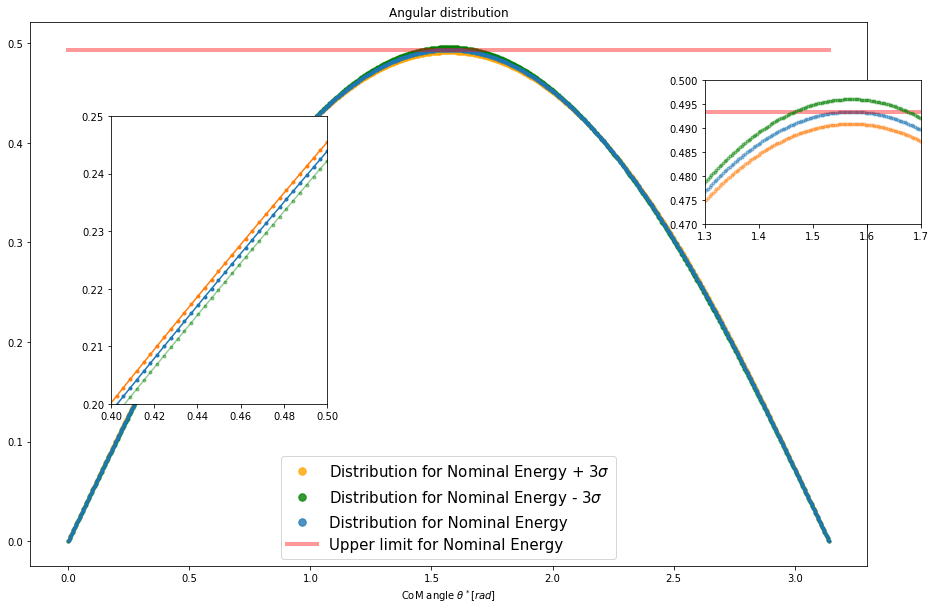

In [60]:
line_theta = [0, np.pi]
line_y = [np.mean(upper),np.mean(upper)]


fig, axs = plt.subplots(1,1,figsize=(15,10))

xaxis_theta=np.linspace(0,np.pi,1000)
#MAIN PLOT

axs.plot(xaxis_theta,ang(s2,xaxis_theta),marker='.',color='orange',linestyle='None',label='Distribution for Nominal Energy + $3\sigma$',alpha=0.8)
axs.plot(xaxis_theta,ang(s3,xaxis_theta),color='green',marker='.',linestyle='None',label='Distribution for Nominal Energy - $3\sigma$',alpha=0.8) 
axs.plot(xaxis_theta,ang(s,xaxis_theta),marker='.',linestyle='None',label='Distribution for Nominal Energy',alpha=0.8)
axs.set_title('Angular distribution')
axs.set_xlabel('CoM angle $\\theta^*[rad]$')
axs.plot(line_theta, line_y, c='r',lw=4,alpha=0.4, label='Upper limit for Nominal Energy')

axs.legend(loc='best',fontsize=15,markerscale=2.5)

#ZOOM AT LOW ANGLES

sub_axes = plt.axes([0.2, 0.35, .2, .4]) 
sub_axes.plot(xaxis_theta,ang(s,xaxis_theta),marker='.',label='Distribution for Nominal Energy') 
sub_axes.plot(xaxis_theta,ang(s2,xaxis_theta),marker='.',label='Distribution for Nominal Energy+3\sigma') 
sub_axes.plot(line_theta, line_y, c='r',lw=4,alpha=0.4, label='Upper limit for Nominal Energy')
sub_axes.plot(xaxis_theta,ang(s3,xaxis_theta),marker='.',color='green',label='Distribution for Nominal Energy-3\sigma',alpha=0.4) 
#sub_axes.set_title("zoom")
sub_axes.set_xlim(0.4,0.5)
sub_axes.set_ylim(0.2,0.25)

#ZOOM AT MIDDLE ANGLES

sub_axes2 = plt.axes([0.75, 0.6, .2, .2]) 
sub_axes2.plot(xaxis_theta,ang(s,xaxis_theta),marker='.',linestyle='None',label='Distribution for Nominal Energy',alpha=0.4) 
sub_axes2.plot(xaxis_theta,ang(s2,xaxis_theta),marker='.',linestyle='None',label='Distribution for Nominal Energy+3\sigma',alpha=0.4) 
sub_axes2.plot(line_theta, line_y, c='r',lw=4,alpha=0.4, label='Upper limit for Nominal Energy')
sub_axes2.plot(xaxis_theta,ang(s3,xaxis_theta),color='green',marker='.',linestyle='None',label='Distribution for Nominal Energy-3\sigma',alpha=0.4) 
#sub_axes2.set_title("zoom")
sub_axes2.set_xlim(1.3,1.7)
sub_axes2.set_ylim(0.47,0.5)


#sub_axes.legend(fontsize=15)

plt.show()

As con could expect from the theory, the production of muons is favoured by high energy positrons in the direction (parallel or antiparallel) of the beam, whereas the production along orthogonal direction is favoured by positrons at lower energies. However, this dependence, consequence of the term $\cos(\theta)^{2}$ in the $g(\theta^*)$ distribution is negligible for our purposes but still for sake of generality we took into account it.

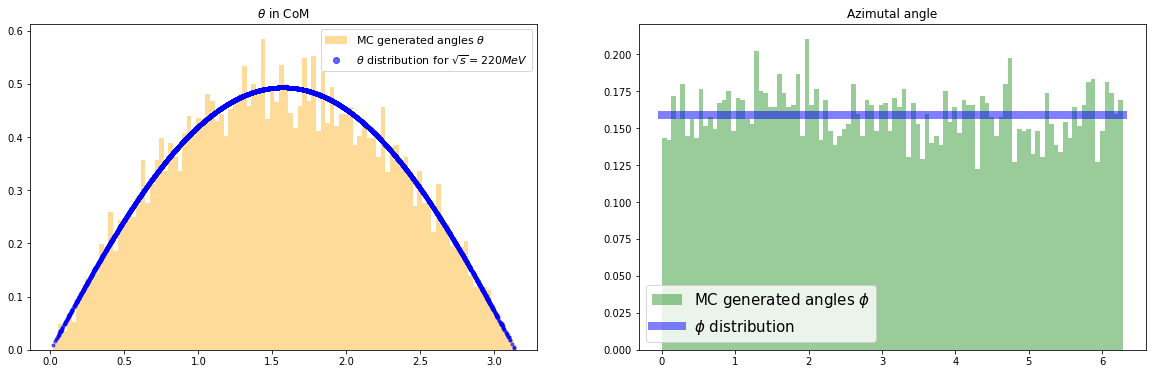

In [61]:

fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].hist(angle_cm,bins=100,density=True, color='orange', alpha=0.4, label='MC generated angles $\\theta$')
ax[0].set_title("$\\theta$ in CoM")
ax[0].plot(angle_cm, ang(s, angle_cm), color='b',linestyle='None', marker='.',label="$\\theta$ distribution for $\\sqrt{s}=220MeV$",alpha=0.6)
ax[0].legend(loc='upper right', fontsize=11,markerscale=2.)

ax[1].hist(phi,bins=100,density=True,color='green',label='MC generated angles $\\phi$',alpha=0.4)
ax[1].set_title("Azimutal angle")
line_x = [0, 2*np.pi]
line_y = [1/(2*np.pi), 1/(2*np.pi)]
ax[1].plot(line_x, line_y, color='b', lw=8,label='$\\phi$ distribution',alpha=0.5)
ax[1].legend(fontsize=15,loc='lower left')

plt.show()


Notice that the distribution is clearly symmetric under $\theta \rightarrow \pi-\theta$ since for each muon emitted at $\theta$ we have a corresponding antimuon emitted at $\pi-\theta$ (or viceversa). For this reason when we will compute the tangent we have to consider also the corresponding opposite value due to the fact that sine is an even function under this transformation but the cosine is an odd one.

Now as done before, we will compute the tangent of these angles and convert it to the lab frame. Since every muon is emitted with different velocities we will employ different Lorentz boost for each particle according to its velocity.

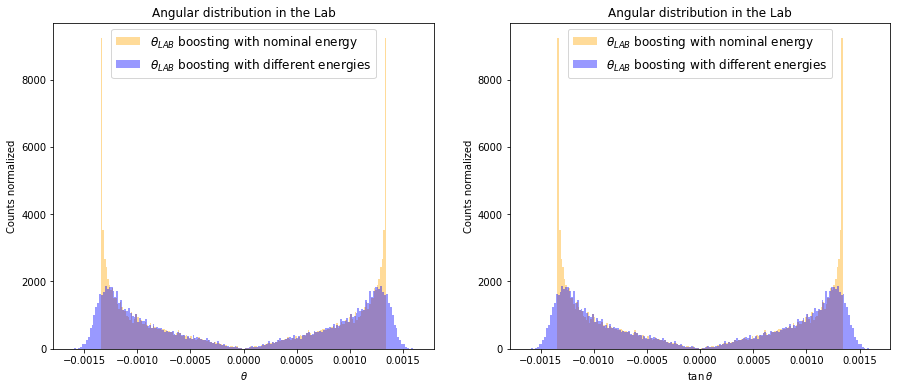

In [62]:
binnumber=90

fig, ax = plt.subplots(1,2,figsize=(15,6))

#USING only one lorentz transformation:
tantheta=np.sin(angle_cm)/(np.mean(gamma_boost)*(np.cos(angle_cm)+np.mean(beta_boost)/np.mean(beta_cm_mu)))
theta_lab=np.arctan(tantheta)

ax[0].hist(theta_lab,bins=binnumber,color='orange',alpha=0.4,density=True,label='$\\theta_{LAB}$ boosting with nominal energy')
ax[0].hist(-theta_lab,bins=binnumber,color='orange',alpha=0.4,density=True)
ax[0].set_title("Angular distribution in the Lab with one boost")
ax[0].set_xlabel("$\\theta$")
ax[0].set_ylabel("Counts normalized")
#ax.set_xlim(0,0.05)

ax[1].hist(tantheta,bins=binnumber, color='orange',alpha=0.4,density=True,label='$\\theta_{LAB}$ boosting with nominal energy')
ax[1].hist(-tantheta,bins=binnumber, color='orange',alpha=0.4,density=True)
ax[1].set_title("Angular distribution in the Lab with one boost")
ax[1].set_xlabel("$ \\tan{\\theta}$")
ax[1].set_ylabel("Counts normalized")
#ax[1].set_xlim(0,0.001)
#ax[1].set_ylim(0,2000)

tantheta=np.sin(angle_cm)/(gamma_boost*(np.cos(angle_cm)+beta_boost/beta_cm_mu))
theta_lab=np.arctan(tantheta)
ax[0].hist(theta_lab,bins=binnumber,color='b',alpha=0.4,density=True,label='$\\theta_{LAB}$ boosting with different energies')
ax[0].hist(-theta_lab,bins=binnumber,color='b',alpha=0.4,density=True)
ax[0].set_title("Angular distribution in the Lab")
#ax.set_xlim(0,0.05)


ax[1].hist(tantheta,bins=binnumber, color='b',alpha=0.4,density=True,label='$\\theta_{LAB}$ boosting with different energies')
ax[1].hist(-tantheta,bins=binnumber, color='b',alpha=0.4,density=True)
ax[1].set_title("Angular distribution in the Lab")
ax[1].set_xlabel("$ \\tan{\\theta}$")
#ax[1].set_xlim(0,0.001)
#ax[1].set_ylim(0,2000)



ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
plt.show()

Using a different Lorentz boost for each muon according to its velocity leads to a more spread distribution.
Notice that since the angles are very little the tangent and the angle itself in radiants are almost the same.


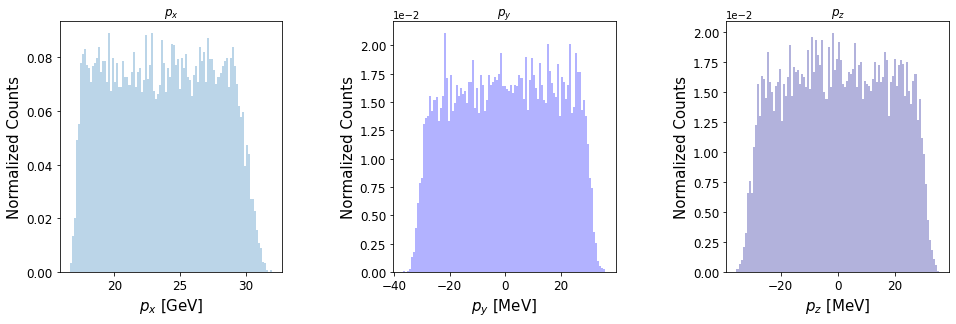

In [63]:
def gamma_from_E(E, m):
    return (E/m);
def beta_from_E(E, m):
    return (np.sqrt((E**2-m**2)/E**2))
def p_from_E(E,m):
    return np.sqrt(E**2-m**2)
def E_lab_from_cm(beta_boost,theta_cm,gamma_boost=1/np.sqrt(1-beta_boost**2)):
    return (gamma_boost*(E_cm+beta_boost*p_cm*np.cos(theta_cm)))

#ENERGY and MOMENTUM of the muons in the LAB
E_mu_lab=(gamma_boost)*(M/2+(beta_boost)*p_from_E(M/2,mu)*np.cos(angle_cm))
p_mu_lab=p_from_E(E_mu_lab,mu)

bins=100
fig, ax4 = plt.subplots(1,3,figsize=(15,6))

fig.tight_layout(pad=8.0)

#Px
ax4[0].hist(p_mu_lab*np.cos(theta_lab)*10**(-3),bins=bins,alpha=0.3,density=True)
ax4[0].ticklabel_format(axis="x", style="plain", scilimits=(0,0))
ax4[0].set_title('$p_x$')
ax4[0].set_xlabel('$p_x$ [GeV]',fontsize=15)
ax4[0].set_ylabel('Normalized Counts',fontsize=15)
ax4[0].tick_params(axis='both', which='major', labelsize=12)

#Py
ax4[1].hist(p_mu_lab*np.sin(theta_lab)*np.sin(phi),bins=bins,color='blue',alpha=0.3,density=True)
ax4[1].set_title('$p_y$')
ax4[1].set_xlabel('$p_y$ [MeV]',fontsize=15)
ax4[1].set_ylabel('Normalized Counts',fontsize=15)
ax4[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax4[1].tick_params(axis='both', which='major', labelsize=12)

#Pz same as Py
ax4[2].hist(p_mu_lab*np.sin(theta_lab)*np.cos(phi),bins=bins,color='darkblue',alpha=0.3,density=True)
ax4[2].set_title('$p_z$')
ax4[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax4[2].set_xlabel('$p_z$ [MeV]',fontsize=15)
ax4[2].set_ylabel('Normalized Counts',fontsize=15)
ax4[2].tick_params(axis='both', which='major', labelsize=12)

plt.show()

Notice that for each positron a pair of muon and antimuon will be produced hence due to momentum conservation the momenta along y and z of the pairs will be opposite whereas the momenta along x will be such that momentum conservation is satisfied:

In [64]:
#dataframe
p_mu=np.array([])
#p_mu = np.concatenate(p_mu_lab*np.cos(theta_lab),p_mu_lab*np.sin(theta_lab)*np.sin(phi))
#p_mu[1] = p_mu_lab*np.sin(theta_lab)*np.sin(phi)
#p_mu[2] = p_mu_lab*np.sin(theta_lab)*np.cos(phi)
print("Denoting with px, py, pz the momenta of the muons and p2x, p2y p2z momenta of the antimuon")
p_mu=np.concatenate((p_mu_lab*np.cos(theta_lab),p_mu_lab*np.sin(theta_lab)*np.sin(phi)))
p_mu=np.concatenate((p_mu,p_mu_lab*np.sin(theta_lab)*np.cos(phi)))

#separating the array in a N*3
p_mu=p_mu.reshape(3,N)
p_mu=p_mu.T
df = pd.DataFrame(data=p_mu,columns=["px", "py",'pz'])
df['p2x']=p_pos_lab-df.px      #momentum conservation
df['p2y']=-df.py
df['p2z']=-df.pz
df['p_tot_x']=df.px+df.p2x
df.to_csv('Events_gaussian_beam.csv')
df

Denoting with px, py, pz the momenta of the muons and p2x, p2y p2z momenta of the antimuon


,px,py,pz,p2x,p2y,p2z,p_tot_x
0,25658.665940,5.498611,29.443005,21850.869639,-5.498611,-29.443005,47509.535579
1,25071.188921,-27.753831,14.580194,22597.116592,27.753831,-14.580194,47668.305513
2,30777.148798,-2.751358,-10.033905,17188.947224,2.751358,10.033905,47966.096022
3,28544.321091,15.308538,1.748685,18312.296912,-15.308538,-1.748685,46856.618002
4,22657.982924,23.771306,-5.487327,23375.799784,-23.771306,5.487327,46033.782708
...,...,...,...,...,...,...,...
9995,25339.822353,-15.158945,21.956937,21461.041834,15.158945,-21.956937,46800.864187
9996,26463.998800,-0.488589,-26.275458,20649.714010,0.488589,26.275458,47113.712810
9997,21330.635754,18.539709,-17.774594,25278.708384,-18.539709,17.774594,46609.344138
9998,24363.726975,23.620969,17.452157,22759.805286,-23.620969,-17.452157,47123.532262


8. Given that the electrons traversing the target lose energy ($E(x)=E_0 \exp{-x/X_0}$), with $z$ the longitudinal coordinate of the target, 
the one parallel to the beam direction and $X_0$ is the Beryllium radiation length), compute the
nominal beam energy $E_0$ such that muon pairs can be generated along the whole length of the target. 

The threshold energy for muon production in the laboratory frame should be slightly higher than the sum of the two 
muons masses:

$$ \sqrt{s}_{\text{th}} \sim 2m_{\mu} \implies s_{\text{th}} \sim 4m_{\mu}^2 $$

Assuming the target's electrons at rest, we can express $s$ as follows:

$$     s = (p_{e^+}+p_{e^-})^2 = \vec p_{e_+}^2+m_{e_-}^2+m_{e_-}^2+2E_{e_+}m_{e_-}-\vec p_{e_+}^2     $$

Hence, the threshold production condition reads:

$$  E_{e^+,th} > \frac{4m_{\mu}^2 - 2m_{e^-}^2   }{2m_{e^-}} \sim 43.7~\text{GeV} $$

So, with the purpose of having a threshold energy along the whole target we need to impose the same condition at the end
of the latter, i.e. at $x_{max}=l=3$ cm where $l$ is the lenght of the target. 

$$ E_{e^+,th}(x) = E_{e^+,0} \cdot \text{e}^{-l/X_0}  \implies E_{e^+,0} > \frac{4m_{\mu}^2 - 2m_{e^-}^2   }{2m_{e^-}} \cdot \text{e}^{l/X_0} \sim 47.6~\text{GeV} $$

Threshold energy: 47571.03 MeV


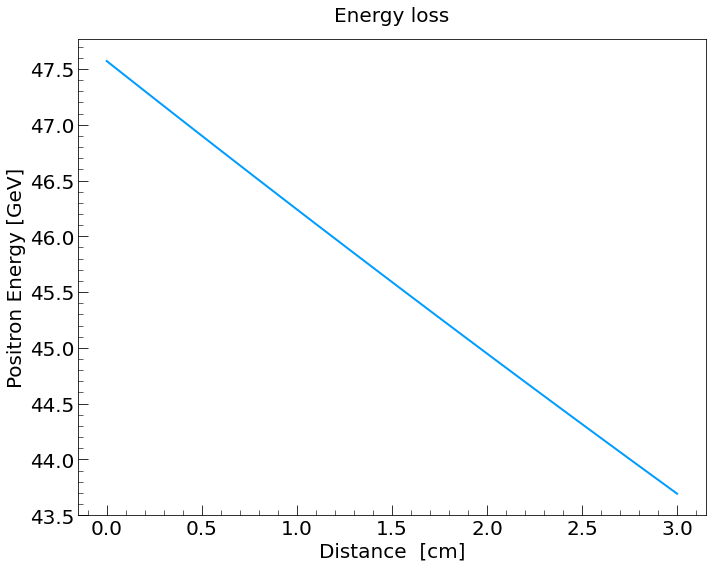

In [65]:
rad_length = 35.28  # Radiation length of Beryllium [cm]
l = 3               # Target thickness [cm]

E_0th = ( (4*mu**2-2*me**2)/(2*me) )*np.exp(l/rad_length)

print ('Threshold energy: {:.2f} MeV'.format(E_0th)) 

### Plot of energy loss in Beryllium ###

x = np.linspace(0,3,100) # distances from 0 to 3 cm 
e = E_0th * np.exp(-x/rad_length) * 1e-03

fig, ax = plt.subplots(1, figsize = (10,8))
ax.plot(x,e, lw=2, ls='-', color = '#009CFF', )

ax.set_title('Energy loss' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance  [cm]',fontsize = 20)
ax.set_ylabel('Positron Energy [GeV]',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()

fig.tight_layout()
plt.show()


The energy loss in Beryllium is not significant as the exponential trend is not visible from the plot. Indeed along the 
3 cm target, the positrons lose in average roughly 0.4 GeV. This aspect can be further analyzed by comparing the energy loss
trend in different materials. Therefore, we consider a some elements, e.g. Litium, Carbon, Iron. 

Put reference to https://pdg.lbl.gov/2021/AtomicNuclearProperties/

In [66]:
# Build a dataframe with some material and corresponding properties

Material = [   'Li',  'Be',    'B',    'C',     'Al',   'Fe',   'Cu',   'W',    'Pb']        # Material 
Z        = [   3,     4,       5,      6,    13,     26,      29,     74,     82]            # Atomic number  
M        = [ 6.941, 9.01218, 10.811, 12.0107,  26.9815, 55.6934,63.546, 183.84, 207.2]       # Molar mass [g/mol]
density  = [ 0.5340, 1.8477 , 2.370,   2.0,   2.699 ,   7.874 ,  8.96,   19.3 ,  11.35]      # Density [g/cm^3]
X0       = [ 155.0, 35.28,    22.23,   21.35, 8.897 ,  1.757,   1.436,   0.3504,  0.5612]    # Radiation lenght [cm]

# Create a dictionary with materials and properties 
dic_properties = {'Material': Material, 'Z': Z, 'M': M,'Density': density, 'X0': X0}
properties = pd.DataFrame(data=dic_properties)
properties


,Material,Z,M,Density,X0
0,Li,3,6.94100,0.5340,155.0000
1,Be,4,9.01218,1.8477,35.2800
2,B,5,10.81100,2.3700,22.2300
3,C,6,12.01070,2.0000,21.3500
4,Al,13,26.98150,2.6990,8.8970
5,Fe,26,55.69340,7.8740,1.7570
6,Cu,29,63.54600,8.9600,1.4360
7,W,74,183.84000,19.3000,0.3504
8,Pb,82,207.20000,11.3500,0.5612


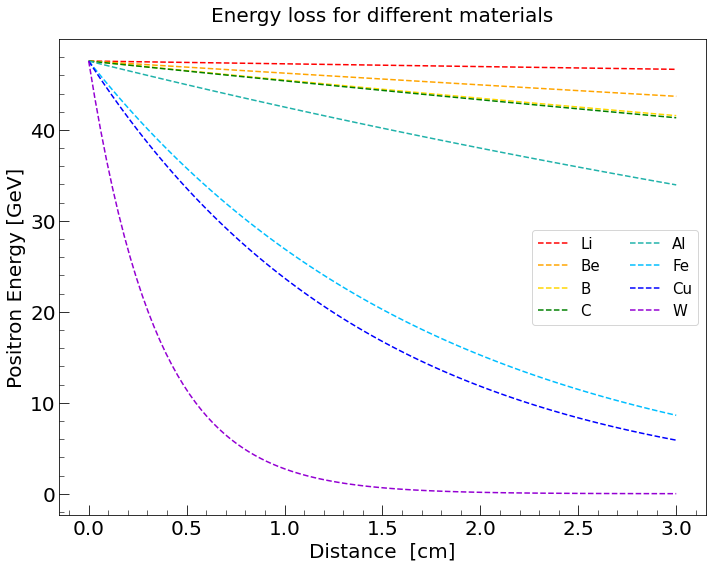

In [67]:

### Plot of energy loss or different materials ###
colors = ['red', 'orange', 'gold', 'green', 'lightseagreen', 'deepskyblue', 'blue', 'darkviolet']

x = np.linspace(0,3,100) # distances from 0 to 3 cm 

fig, ax = plt.subplots(1, figsize = (10,8))

for i in range(0,8):
    ax.plot(x, E_0th * np.exp(-x/properties.at[i,'X0'])* 1e-03,label = properties.at[i,'Material'], color = colors[i],ls='dashed')
    
ax.set_title('Energy loss for different materials' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance  [cm]',fontsize = 20)
ax.set_ylabel('Positron Energy [GeV]',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()

ax.legend(loc='best', fontsize=15, ncol = 2)

fig.tight_layout()
plt.show()

# 9) Simulation with energy loss
We now take into account the loss of energy along the target when generating the events, both for a monochromatic and non-monochromatic beam. 
## 9.1 Monochromatic beam
From the previous point we have seen that the minimum positron energy required to have muon pairs production along the whole target, i.e. a non-zero
cross section, is equal to $ E_{0,th} \sim 47.6~\text{GeV} $. This value corresponds to an invariant mass $\sqrt{s} \sim 220.6$ MeV. So, in order
to satisty the aforementioned condition, we choose a CoM energy slightly greater, i.e. $\sqrt{s} = 225$ MeV, which corresponds to a positron 
initial energy E $_0 \sim 49.54~\text{GeV}$. The energy loss leads to a variable pair-production probability depending on the cross section along the target. 
We need to generate the position along the x-axis inside the target and then retrieve the angular distribution of the emitted muons in the CoM frame, 
using the **acceptance-rejection method**. So we'll proceed in the following way:

- we first need to compute the invariant mass depending on the initial energy $\text{E}_0$ and on the position $x$;
- then we compute the cross section, according to the initail energy and point of interaction;
- we divide the target into a range of discrete intervals in order to obtain the number of interactions in function of the travelled distance;
- knowing the total number of produced muon pairs (in one week), we can infer how many interactions occur in each slice of the target lenght  

In [68]:
def s_att(x,E0):
    '''
        Function that calculates s in function of the initial energy E_0
        and of the position x inside the target. 

        Parameters:
        x: position in the medium [cm]
        E0: initial positrons energy [MeV]

        Returns:
        s [MeV^2]
    '''

    return 2 * me**2 + 2 * E0 *np.exp(-x/rad_length) * me

def sigma_att(x,E0):
    '''
        Function that calculates the cross section in function of
        the initial energy E_0 and of the position x inside the target. 

        Parameters:
        x: position in the medium [cm]
        E0: initial positrons energy [MeV]

        Returns:
        sigma [] ### UNITÀ DI MISURA
    '''

    return sigma(s_att(x,E0))

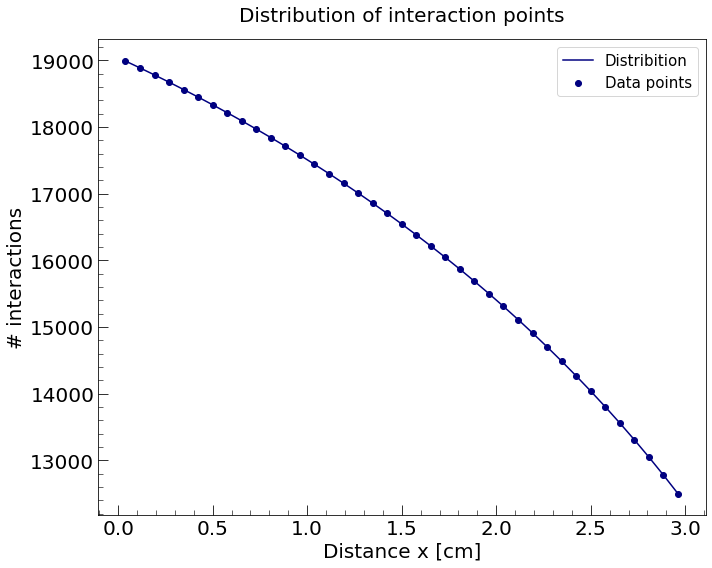

In [69]:
E_0 = 49.54 * 1000  # positrons initial energy [MeV]
n_grid = 40         # number of grid points 

scale = (l/n_grid) *  389.4 * 1e-24 * rho_electrons  # scaling factor and conversion from MeV^-2 to cm^2 

points = np.linspace(0,l,n_grid)            # array of grid points
points = (points[1:] + points [:-1]) / 2    # we take the middle point of each piece 

T     = 3600 * 24 * 7                       # seconds in a week
n_part_tot = T * 10**6                      # number of pairs produced in a week considering f = 10^6 Hz

particles = np.zeros(n_grid)                # initialize array to store number of particles in each interval
particles[0] = n_part_tot                   # initial number 

for i in range(n_grid-1):
    prob = 1 - scale * sigma_att(points[i],E_0)  # probability of not interacting -> used to calculate how many particles 
                                                 # can still interact after at a certain distance 
    particles[i+1] = particles[i] * prob  

n_interactions = particles[:-1] - particles[1:] # subtract the number of particles in interval [i+1] from the one in [i]

# normalize to total number of interactions 

fig, ax = plt.subplots(1, figsize = (10,8))

# use intep1d to find the distribution for the interaction points
dist = interp1d(points,n_interactions, fill_value ='extrapolate') 

# if we want to find the normalized ditribution we need to divide buìy the sum of the # of interactions  
# n_interactions_nor = n_interactions / n_interactions.sum()
# dist = interp1d(points,n_interactions,fill_value ='extrapolate")
                        
ax.plot(points, dist(points), color = 'navy',label = 'Distribition')
ax.scatter(points, n_interactions, marker = 'o', color = 'navy', label = 'Data points')

ax.set_title('Distribution of interaction points' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance x [cm]',fontsize = 20)
ax.set_ylabel('# interactions',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()
ax.legend(loc='best', fontsize=15, ncol = 1)


fig.tight_layout()
plt.show()

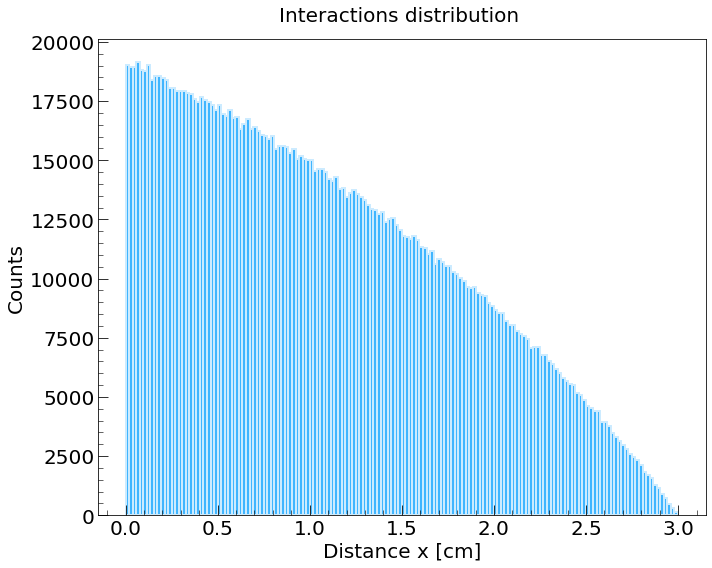

In [70]:
# accept-reject method according to the distribution above
accepted_events = []
N = 10**6

'''
Same result but way less efficient!!

while len(accepted_events) < N: 
    dist_points = np.random.uniform(0,l)
    check = np.random.uniform(dist(3),dist(0))
    if(check < dist(dist_points)):
        accepted_events.append(dist_points)
'''

dist_points = np.random.uniform(0, l, 3*N) 
check = np.random.uniform(dist(3), dist(0), 3*N)   
accepted_events = dist_points[check < dist(dist_points)]


fig, ax = plt.subplots(1, figsize = (10,8))

sns.histplot(x=accepted_events,
             ax=ax,
             stat='count',
             lw=2,
             edgecolor   = '#ccebff',
             color       = '#009CFF'
              )

ax.set_title('Interactions distribution ', fontsize = 20, pad = 18)
ax.set_xlabel('Distance x [cm]',fontsize = 20)

# plot settings   
ax.set_ylabel('Counts',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()


fig.tight_layout()
plt.show()

In [71]:
# Apply accept-reject on previously accepted points according to cross section in each interval

# Generate angles in CoM frame 
angles = np.random.uniform(0, np.pi, len(accepted_events))
check_ang = np.random.uniform(0, ang(s_att(accepted_events, E_0),np.pi/2), len(accepted_events)) 

# create Dataframe 
df_energies_mono_att = pd.DataFrame(s_att(accepted_events, E_0), columns = ['Energy']) # s values of accepted events 
df_energies_mono_att['Angles'] = angles                                                
df_energies_mono_att['emission_point'] = accepted_events                               # column with interaction point 
df_energies_mono_att['check']  = check_ang

# accept only the events that satisfy the condition, i.e. follow the wanted distribution                                        
df_energies_mono_att[r'$\theta^*$']  = df_energies_mono_att.Angles[df_energies_mono_att.check < ang(df_energies_mono_att.Energy, df_energies_mono_att.Angles)] 
# drop columns with NaN -> events that do not follow the distribution 
df_energies_mono_att = df_energies_mono_att.dropna()
# keep only N events 
df_energies_mono_att = df_energies_mono_att.iloc[:N]

df_energies_mono_att

,Energy,Angles,emission_point,check,$\theta^*$
2,49557.375307,2.488248,0.755673,0.028017,2.488248
3,49943.616069,0.871774,0.481771,0.265761,0.871774
5,47639.688602,0.432659,2.148009,0.032254,0.432659
6,49866.040328,1.777261,0.536613,0.306670,1.777261
8,47720.853562,2.320906,2.087952,0.030760,2.320906
...,...,...,...,...,...
1546025,48735.062047,2.628717,1.345997,0.171694,2.628717
1546028,50216.885679,0.627071,0.289258,0.061564,0.627071
1546029,49633.358188,1.707275,0.701622,0.356409,1.707275
1546030,48539.780168,0.552556,1.487650,0.186814,0.552556


To simulate the events with different values of s, starting from `generate_beam`, we slightly modify the function
in order to give as input a DataFrame containing different energies.

In [72]:

def generate_beam_df(df):


    batch_size = df.shape[0]
    pnorm = norm(df.Energy) # Norm of muon 3-momentum in CM
    
    # Compute inverse CDF of g(theta*) by interpolation 
    theta_star = np.linspace(0, np.pi, N)
    inv_cdf = interp1d(g_cdf(df.Energy, theta_star), theta_star, fill_value='extrapolate')

    # Sample angles
    num_samples = N
    unif_samples = np.random.uniform(size=batch_size)

    phis = np.random.uniform(0, 2 * np.pi, size=batch_size)
    thetas = inv_cdf(unif_samples)
    
    
    # Compute cartesian components of 3-vector
    px_cm = pnorm * np.cos(df.Angles)
    py_cm = pnorm * np.sin(df.Angles) * np.cos(phis)
    pz_cm = pnorm * np.sin(df.Angles) * np.sin(phis)


    _,px1 = boost_coordinates(df.Energy, px_cm)  # px for first muon
    _,px2 = boost_coordinates(df.Energy, -px_cm) # px for second muon
    # py and pz are orthogonal to boost axis, and so they remain the same
    
    return np.stack((px1, py_cm, pz_cm, px2, -py_cm, -pz_cm), axis=1)    


# generate events 
events_att = generate_beam_df(df_energies_mono_att)
# save events in txt file and dataframe 
np.savetxt("Momenta_monochromatic_attenuated.txt", events_att) # save to file
df_monochromatic_att = pd.DataFrame(events_att, columns = [  '$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])
df_monochromatic_att.to_csv('Events_attenuated_mono.csv')
df_monochromatic_att


,$px_{\mu_1}$,$py_{\mu_1}$,$pz_{\mu_1}$,$px_{\mu_2}$,$py_{\mu_2}$,$pz_{\mu_2}$
0,18189.747228,9.691076,-18.945502,30300.423901,-9.691076,18.945502
1,29550.498737,-20.452242,18.879915,19317.599550,20.452242,-18.879915
2,28603.354389,7.844015,-8.346217,18010.407106,-7.844015,8.346217
3,22779.321759,-34.675815,-6.756804,26012.870559,34.675815,6.756804
4,19312.257738,-17.002082,-11.009838,27380.921690,17.002082,11.009838
...,...,...,...,...,...,...
999995,17831.421586,15.550685,-1.944546,29854.136090,-15.550685,1.944546
999996,31188.621300,20.377115,-7.971222,17946.864630,-20.377115,7.971222
999997,23235.911518,-29.380969,18.930560,25328.607005,29.380969,-18.930560
999998,29465.833235,-8.100875,14.210548,18028.645889,8.100875,-14.210548


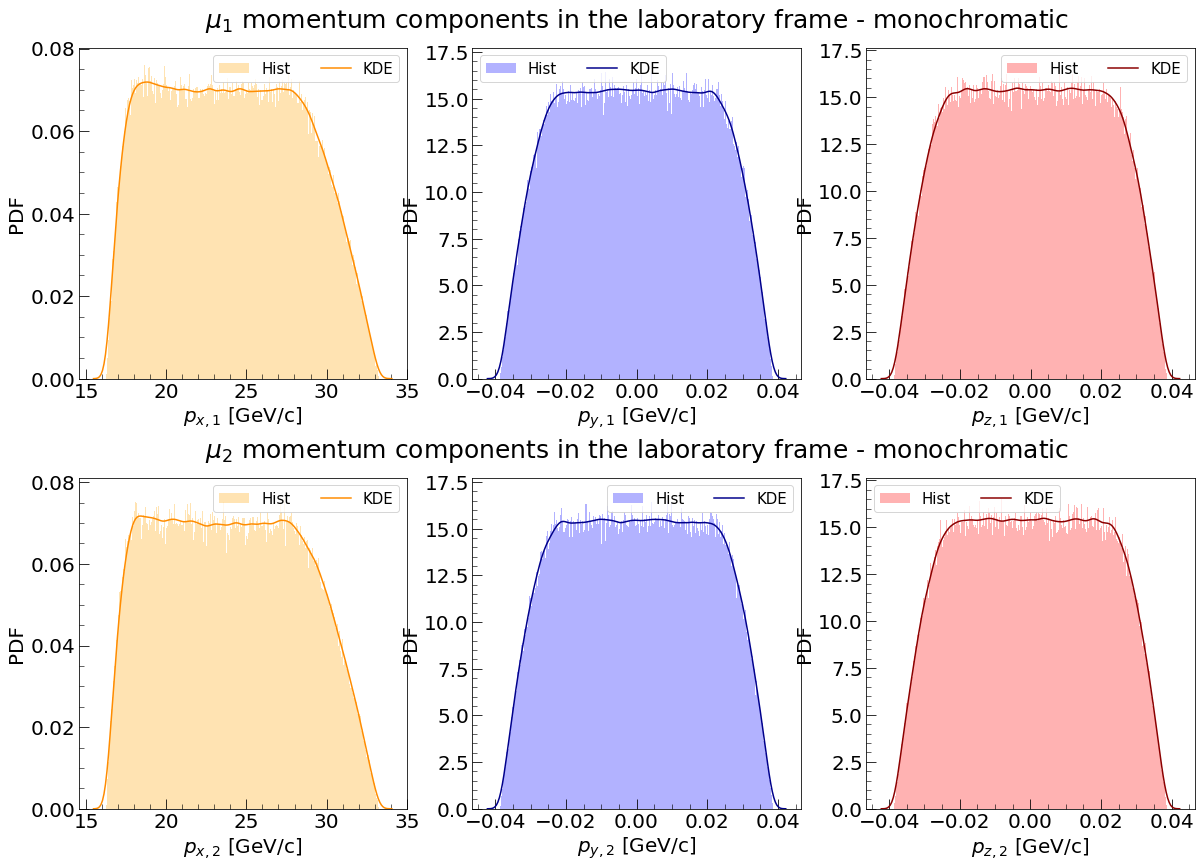

In [73]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

# plotting momentum components distribution in the LAB frame


### MUON 1 ###
# px
sns.distplot(df_monochromatic_att['$px_{\mu_1}$']/1000,
             ax = ax[0][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )

            
# py
sns.distplot(df_monochromatic_att['$py_{\mu_1}$']/1000,
             ax = ax[0][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkblue',   'label': 'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic_att['$pz_{\mu_1}$']/1000,
             ax = ax[0][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred',   'label': 'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[0][0].set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)
ax[0][1].set_xlabel(r'$p_{y,1}$ [GeV/c]',fontsize = 20)
ax[0][2].set_xlabel(r'$p_{z,1}$ [GeV/c]',fontsize = 20)

ax[0][1].set_title('$\mu_1$ momentum components in the laboratory frame - monochromatic',fontsize = 25,pad = 20)


### MUON 2 ###
# px
sns.distplot(df_monochromatic_att['$px_{\mu_2}$']/1000,
             ax = ax[1][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# py
sns.distplot(df_monochromatic_att['$py_{\mu_2}$']/1000,
             ax = ax[1][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws = {'color':'darkblue','label':'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic_att['$pz_{\mu_2}$']/1000,
             ax = ax[1][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred', 'label':'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[1][0].set_xlabel(r'$p_{x,2}$ [GeV/c]',fontsize = 20)
ax[1][1].set_xlabel(r'$p_{y,2}$ [GeV/c]',fontsize = 20)
ax[1][2].set_xlabel(r'$p_{z,2}$ [GeV/c]',fontsize = 20)

ax[1][1].set_title('$\mu_2$ momentum components in the laboratory frame - monochromatic',fontsize = 25, pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)


plt.subplots_adjust(hspace=.3)
plt.show()

